In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import csv
import copy
import numpy as np
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Dataset**

In [0]:
data_dir = '/content/drive/My Drive/A05_P2_Dataset'

In [0]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

# data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train':trainloader, 'val':validloader}

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['0__covid', '1__pneumonia', '2__normal']


In [0]:
def onehot(labels):
    arr = np.array(labels)
    out = np.zeros((arr.size, 3))
    out[np.arange(arr.size),arr] = 1
    out[out[:,0] == 1] = np.array([1,1,0])
    out = torch.Tensor(out)
    return out.to(device)

class focal_loss(nn.Module):
    def __init__(self, alpha=0.5, gamma=1.2):
        super(focal_loss,self).__init__()
        self.a = alpha
        self.g = gamma
        
    def forward(self, outputs, labels):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, labels)
        pt = torch.exp(-bce_loss)
        loss = self.a * ((1-pt)**self.g) * bce_loss
        return loss.mean()

**Training Function**

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    err_tr = []
    err_val = []
    acc_tr = []
    acc_val = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 40)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = onehot(labels)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs.data)
                    preds[preds>=0.5] = 1
                    preds[preds<0.5] = 0
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                running_corrects += (preds == labels).prod(1).sum().item()

            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total

            print('{} ==> Loss: {:.4f} , Acc: {:.2f} %'.format(phase, epoch_loss, epoch_acc*100))
            
            if phase == 'train':
                err_tr.append(epoch_loss)
                acc_tr.append(epoch_acc*100)
            else:
                err_val.append(epoch_loss)
                acc_val.append(epoch_acc*100)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f} %'.format(best_acc*100))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, err_tr, acc_tr, err_val, acc_val

*** ----------------> VGG-16 Model <---------------- ***

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze all the layers except the last FC layers
for param in vgg16.parameters():
    param.requires_grad = True

#### Use this for unfreezing CNN layers
# for i in [17,19,21,24,26,28]:
#     for param in vgg16.features[i].parameters():
#         param.requires_grad = True

# Fully connected layer architecture
fc_layers = []
fc_layers.extend( [ nn.Linear( vgg16.classifier[0].in_features , 96*10+100 , bias=True ) ] )
fc_layers.extend( [ nn.ReLU( inplace=True ) ] )
fc_layers.extend( [ nn.Dropout( p=0.5, inplace=False ) ] )
fc_layers.extend( [ nn.Linear( 96*10+100 , len(class_names) ) ] )

# Modifying dense layers in VGG16 architecture
vgg16.classifier = nn.Sequential(*fc_layers)

# Unfreeze FC layers
for param in vgg16.classifier.parameters():
    param.requires_grad = True

# Printing modified VGG16 architecture
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Printing parameter that needs to be updated for VGG16

for name, param in vgg16.named_parameters():
    if param.requires_grad:
       print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
criterion = focal_loss(alpha=0.8, gamma=0.5)
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [0]:
vgg16 = vgg16.to(device)

In [0]:
##### training
model_vgg, err_tr, acc_tr, err_val, acc_val = train_model( vgg16, criterion, optimizer, num_epochs = 20 )

Epoch 1/20
----------------------------------------
train ==> Loss: 0.2123 , Acc: 70.35 %
val ==> Loss: 0.1443 , Acc: 85.83 %

Epoch 2/20
----------------------------------------
train ==> Loss: 0.1506 , Acc: 82.37 %
val ==> Loss: 0.1184 , Acc: 88.85 %

Epoch 3/20
----------------------------------------
train ==> Loss: 0.1395 , Acc: 83.48 %
val ==> Loss: 0.1114 , Acc: 89.97 %

Epoch 4/20
----------------------------------------
train ==> Loss: 0.1288 , Acc: 85.05 %
val ==> Loss: 0.1050 , Acc: 87.58 %

Epoch 5/20
----------------------------------------
train ==> Loss: 0.1214 , Acc: 85.87 %
val ==> Loss: 0.1033 , Acc: 90.13 %

Epoch 6/20
----------------------------------------
train ==> Loss: 0.1163 , Acc: 86.45 %
val ==> Loss: 0.1095 , Acc: 89.49 %

Epoch 7/20
----------------------------------------
train ==> Loss: 0.1166 , Acc: 86.52 %
val ==> Loss: 0.0925 , Acc: 91.40 %

Epoch 8/20
----------------------------------------
train ==> Loss: 0.1117 , Acc: 87.37 %
val ==> Loss: 0.0963 

In [0]:
plt.plot( range(20) , err_tr )
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Error')
plt.title('Cross Entropy Error Curve for Training data while training')
plt.show()
plt.plot( range(20) , acc_tr )
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Training data while training')
plt.show()
plt.plot( range(20) , err_val )
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Error')
plt.title('Cross Entropy Error Curve for Validation data while training')
plt.show()
plt.plot( range(20) , acc_val )
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Validation data while training')
plt.show()

In [0]:
torch.save(model_vgg.state_dict(), '/content/drive/My Drive/vgg16_focal_loss.pth')

*********************************************

*********************************************

*********************************************

*********************************************

*** ----------------> ResNet-18 Model <----------------  ***

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

# Freeze all the layers except the last FC layers
for param in resnet18.parameters():
    param.requires_grad = True

#### Use this for unfreezing CNN layers
# for param in resnet18.layer4.parameters():
#     param.requires_grad = True

### Use this for unfreezing 1 CNN layer
# for param in resnet18.layer4[1].conv2.parameters():
#     param.requires_grad = True
# for param in resnet18.layer4[1].bn2.parameters():
#     param.requires_grad = True

# Modifying dense layers in VGG16 architecture
fc_layers = []
fc_layers.extend( [ nn.Linear( resnet18.fc.in_features , 96*10+100 , bias=True ) ] )
fc_layers.extend( [ nn.ReLU( inplace=True ) ] )
fc_layers.extend( [ nn.Dropout( p=0.5, inplace=False ) ] )
fc_layers.extend( [ nn.Linear( 96*10+100 , len(class_names) ) ] )
resnet18.fc = nn.Sequential( *fc_layers )

# Unfreeze FC layers
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Printing modified VGG16 architecture
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Printing parameter that needs to be updated for ResNet18

for name, param in resnet18.named_parameters():
    if param.requires_grad:
       print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [0]:
criterion = focal_loss(alpha=1, gamma=0)
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9)

In [0]:
resnet18 = resnet18.to(device)

In [0]:
##### training
model_resnet, err_tr, acc_tr, err_val, acc_val = train_model( resnet18, criterion, optimizer, num_epochs = 20 )

Epoch 1/20
----------------------------------------
train ==> Loss: 0.4635 , Acc: 60.97 %
val ==> Loss: 0.3972 , Acc: 67.52 %

Epoch 2/20
----------------------------------------
train ==> Loss: 0.3806 , Acc: 70.73 %
val ==> Loss: 0.3094 , Acc: 85.67 %

Epoch 3/20
----------------------------------------
train ==> Loss: 0.3285 , Acc: 78.66 %
val ==> Loss: 0.2666 , Acc: 85.67 %

Epoch 4/20
----------------------------------------
train ==> Loss: 0.2921 , Acc: 80.97 %
val ==> Loss: 0.2422 , Acc: 87.42 %

Epoch 5/20
----------------------------------------
train ==> Loss: 0.2793 , Acc: 81.35 %
val ==> Loss: 0.2231 , Acc: 87.58 %

Epoch 6/20
----------------------------------------
train ==> Loss: 0.2684 , Acc: 82.68 %
val ==> Loss: 0.2090 , Acc: 89.17 %

Epoch 7/20
----------------------------------------
train ==> Loss: 0.2659 , Acc: 82.68 %
val ==> Loss: 0.2046 , Acc: 89.49 %

Epoch 8/20
----------------------------------------
train ==> Loss: 0.2558 , Acc: 83.23 %
val ==> Loss: 0.1896 

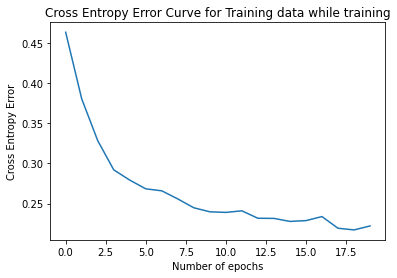

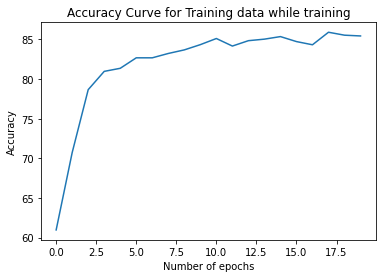

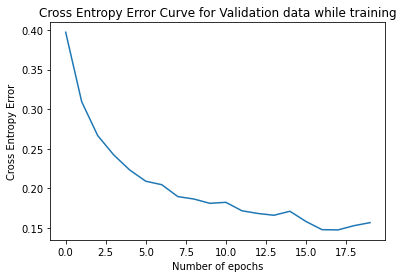

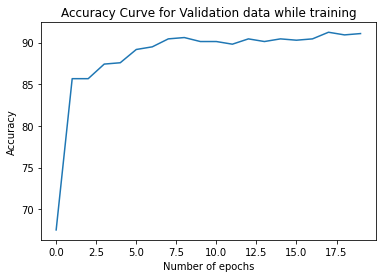

In [0]:
plt.plot( range(20) , err_tr )
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Error')
plt.title('Cross Entropy Error Curve for Training data while training')
plt.show()
plt.plot( range(20) , acc_tr )
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Training data while training')
plt.show()
plt.plot( range(20) , err_val )
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Error')
plt.title('Cross Entropy Error Curve for Validation data while training')
plt.show()
plt.plot( range(20) , acc_val )
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Validation data while training')
plt.show()

In [0]:
torch.save(model_resnet.state_dict(), '/content/drive/My Drive/res18_focal_loss.pth')

*********************************************

*********************************************

*********************************************

*********************************************

*** ----------------> F1-SCORES AND CONFUSION MATRICES <---------------- ***

***Loading VGG16 Model***

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze all the layers except the last FC layers
for param in vgg16.parameters():
    param.requires_grad = True

# Fully connected layer architecture
fc_layers = []
fc_layers.extend( [ nn.Linear( vgg16.classifier[0].in_features , 96*10+100 , bias=True ) ] )
fc_layers.extend( [ nn.ReLU( inplace=True ) ] )
fc_layers.extend( [ nn.Dropout( p=0.5, inplace=False ) ] )
fc_layers.extend( [ nn.Linear( 96*10+100 , len(class_names) ) ] )

# Modifying dense layers in VGG16 architecture
vgg16.classifier = nn.Sequential(*fc_layers)

# Unfreeze FC layers
for param in vgg16.classifier.parameters():
    param.requires_grad = True

# printing trainable parameters
for name, param in vgg16.named_parameters():
    if param.requires_grad:
       print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [0]:
vgg16.load_state_dict(torch.load('/content/drive/My Drive/vgg16_focal_loss.pth'))
vgg16 = vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

***Loading ResNet18 Model***

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

# Freeze all the layers except the last FC layers
for param in resnet18.parameters():
    param.requires_grad = True

# Modifying dense layers in VGG16 architecture
fc_layers = []
fc_layers.extend( [ nn.Linear( resnet18.fc.in_features , 96*10+100 , bias=True ) ] )
fc_layers.extend( [ nn.ReLU( inplace=True ) ] )
fc_layers.extend( [ nn.Dropout( p=0.5, inplace=False ) ] )
fc_layers.extend( [ nn.Linear( 96*10+100 , len(class_names) ) ] )
resnet18.fc = nn.Sequential( *fc_layers )

# Unfreeze FC layers
for param in resnet18.fc.parameters():
    param.requires_grad = True

# printing trainable parameters
for name, param in resnet18.named_parameters():
    if param.requires_grad:
       print(name)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.w

In [0]:
resnet18.load_state_dict(torch.load('/content/drive/My Drive/res18_focal_loss.pth'))
resnet18 = resnet18.to(device)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

***Finding Predictions for Training, Validation and Testing Data***

In [0]:
#### Training
Y_act_train = np.array([0,0,0])
Y_pred_train = np.array([0,0,0])
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), onehot(labels).to(device)
        outputs = vgg16(images)
        Y_act_train = np.vstack(( Y_act_train, np.array(labels.cpu()) ))
        preds = torch.sigmoid(outputs)
        preds[preds>=0.5] = 1
        preds[preds<0.5] = 0
        Y_pred_train = np.vstack(( Y_pred_train, np.array(preds.cpu()) ))

Y_act_train = np.delete(Y_act_train, 0, 0)
Y_pred_train = np.delete(Y_pred_train, 0, 0)

In [0]:
#### Validation
Y_act_val = np.array([0,0,0])
Y_pred_val = np.array([0,0,0])
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), onehot(labels).to(device)
        outputs = vgg16(images)
        Y_act_val = np.vstack(( Y_act_val, np.array(labels.cpu()) ))
        preds = torch.sigmoid(outputs)
        preds[preds>=0.5] = 1
        preds[preds<0.5] = 0
        Y_pred_val = np.vstack(( Y_pred_val, np.array(preds.cpu()) ))

Y_act_val = np.delete(Y_act_val, 0, 0)
Y_pred_val = np.delete(Y_pred_val, 0, 0)

***Generating F1-Scores and Confusion Matrices***

In [0]:
classes = ['Covid-19','Pneumonia','Normal']

In [0]:
# For Training Data
matrix = multilabel_confusion_matrix(Y_act_train, Y_pred_train)
f1 = f1_score(Y_act_train, Y_pred_train, average=None)
for i,cls in enumerate(classes):
    print('F1 score for {} = {:.4f}\nConfusion matrix:'.format(cls, f1[i]))
    print(matrix[i],'\n')

F1 score for Covid-19 = 0.5366
Confusion matrix:
[[5990   10]
 [ 123   77]] 

F1 score for Pneumonia = 0.8812
Confusion matrix:
[[3949   51]
 [ 427 1773]] 

F1 score for Normal = 0.9427
Confusion matrix:
[[1770  430]
 [  50 3950]] 



In [0]:
# For Validation Data
matrix = multilabel_confusion_matrix(Y_act_val, Y_pred_val)
f1 = f1_score(Y_act_val, Y_pred_val, average=None)
for i,cls in enumerate(classes):
    print('F1 score for {} = {:.4f}\nConfusion matrix:'.format(cls, f1[i]))
    print(matrix[i],'\n')

F1 score for Covid-19 = 0.6190
Confusion matrix:
[[599   1]
 [ 15  13]] 

F1 score for Pneumonia = 0.9206
Confusion matrix:
[[397   3]
 [ 31 197]] 

F1 score for Normal = 0.9565
Confusion matrix:
[[196  32]
 [  4 396]] 



**Writing Test Data predictions to a CSV File**

In [0]:
image_names = []
for file in os.listdir("/content/drive/My Drive/A05_P2_Dataset/Test/unlabeled"):
    image_names.append(file)
image_names = np.array(image_names).reshape(len(image_names),1)

In [0]:
#### TESTING
predicted = np.array([0,0,0])
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), onehot(labels).to(device)
        outputs = vgg16(images)
        preds = torch.sigmoid(outputs)
        preds[preds>=0.5] = 1
        preds[preds<0.5] = 0
        predicted = np.vstack(( predicted, np.array(preds.cpu()) ))

predicted = np.delete(predicted, 0, 0)
predicted = predicted.astype(int).astype(str)
print('Testing data predictions are:\n', predicted)

Testing data predictions are:
 [['0' '0' '1']
 ['0' '0' '1']
 ['0' '0' '1']
 ...
 ['0' '1' '0']
 ['0' '0' '1']
 ['0' '0' '1']]


In [0]:
predictions = np.hstack((image_names, predicted))
predictions[:10]

array([['230.jpg', '0', '0', '1'],
       ['605.jpg', '0', '0', '1'],
       ['437.jpg', '0', '0', '1'],
       ['229.jpg', '0', '1', '0'],
       ['524.jpg', '0', '0', '1'],
       ['39.jpg', '0', '0', '1'],
       ['9.jpg', '0', '1', '0'],
       ['586.jpg', '1', '1', '0'],
       ['474.jpg', '1', '1', '0'],
       ['512.jpg', '0', '0', '1']], dtype='<U21')

In [0]:
with open("predictions.csv", 'w') as f:
    csv.writer(f).writerows(predictions)